##### Author  : SIVA VIKNESH 
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com 
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


Combustion:  <br>
Paper: Symbolic regression via neural networks :
\
Chemical kinetics with Arrhenius rate dependence


$$
\dot{\alpha} = -k \alpha  e^{\theta} + \mu
$$

$$
\dot{\theta} = \alpha e^{\theta} - \theta
$$

Parameters: \\(k\\), \\(\mu\\)

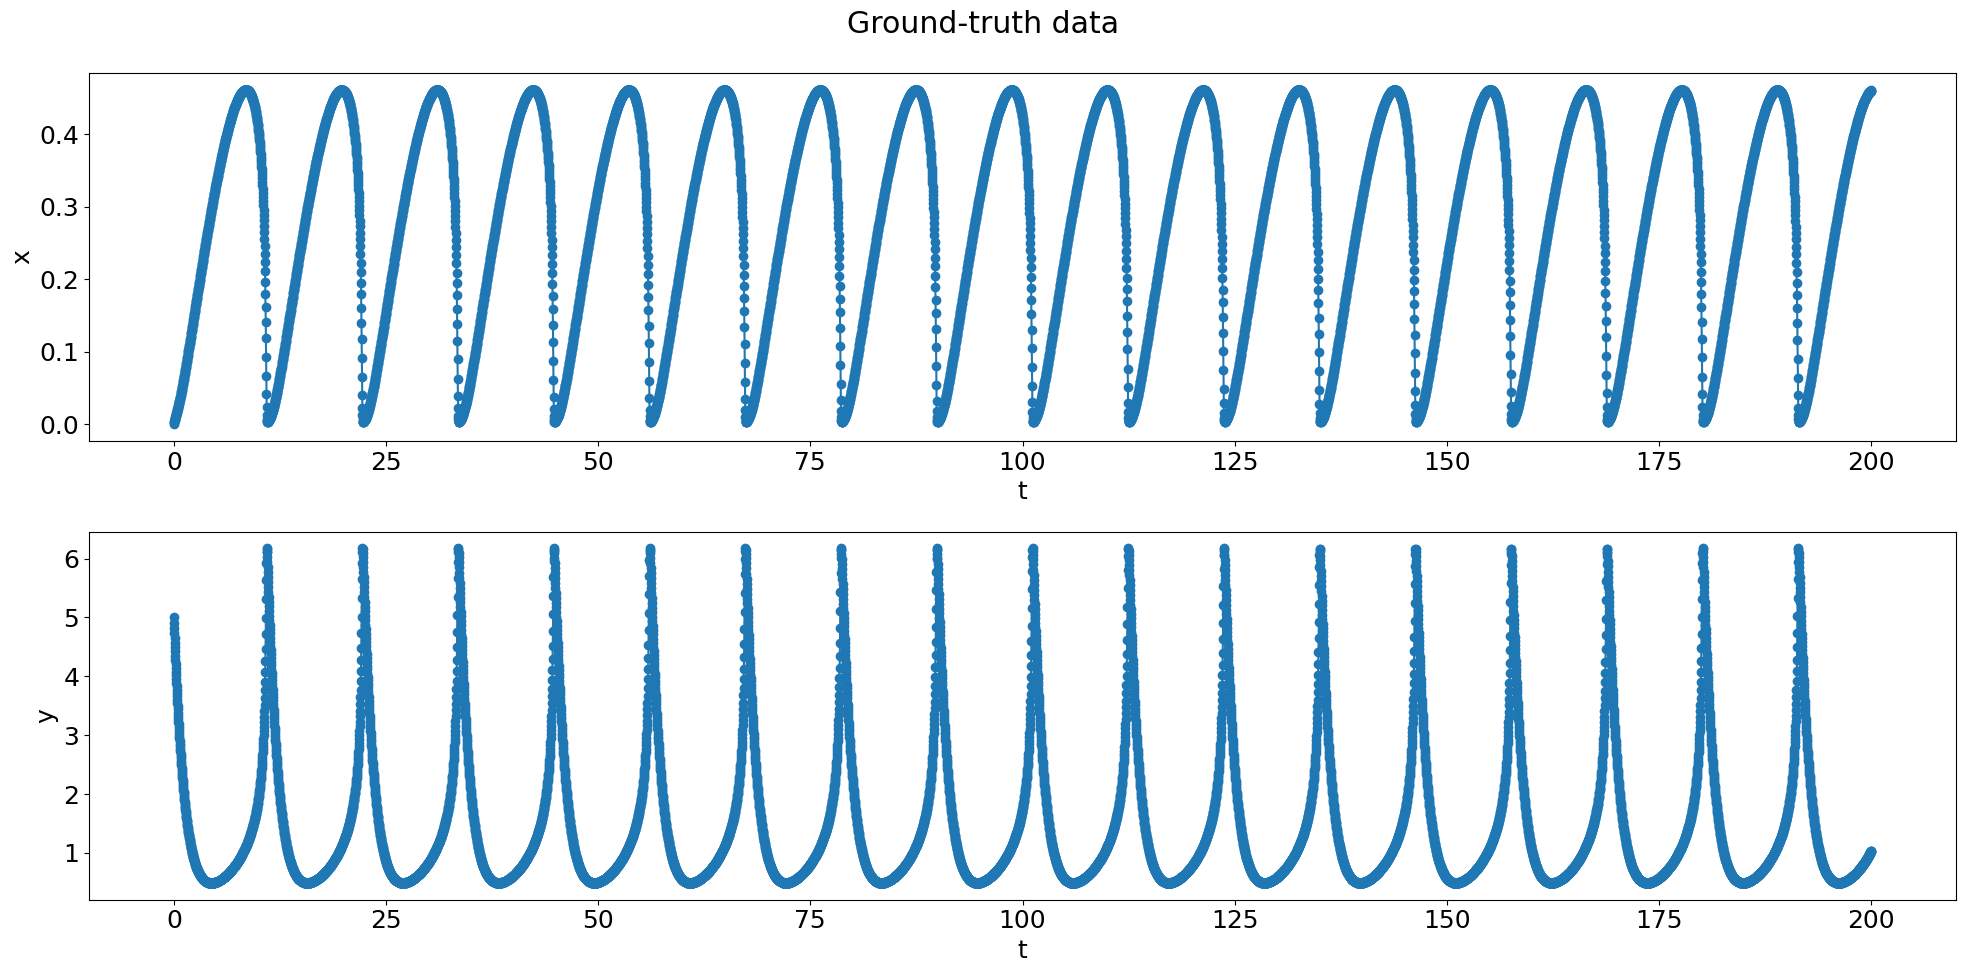

In [2]:
k  = 0.07
mu = 0.1
a  = 1.015
b  = 1.025

def oscillator_deriv(x_y, t0, a =a, b =b,  k=k, mu =mu):
    x, y = x_y
    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0.0,5.0)

# Time points
t = np.linspace(0, 200, 10000)

x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()

In [3]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout = torch.cat((yout, (yin[:, i] * yin[:, j] * yin[:, k]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(x, y, k, a, b, mu):
    dxdt = -k*torch.mul(x,torch.exp(a*y)) + mu
    dydt = torch.mul(x, torch.exp(b*y)) - y
    return torch.vstack((dxdt, dydt)).T


AVAILABLE PROCESSOR: cuda 



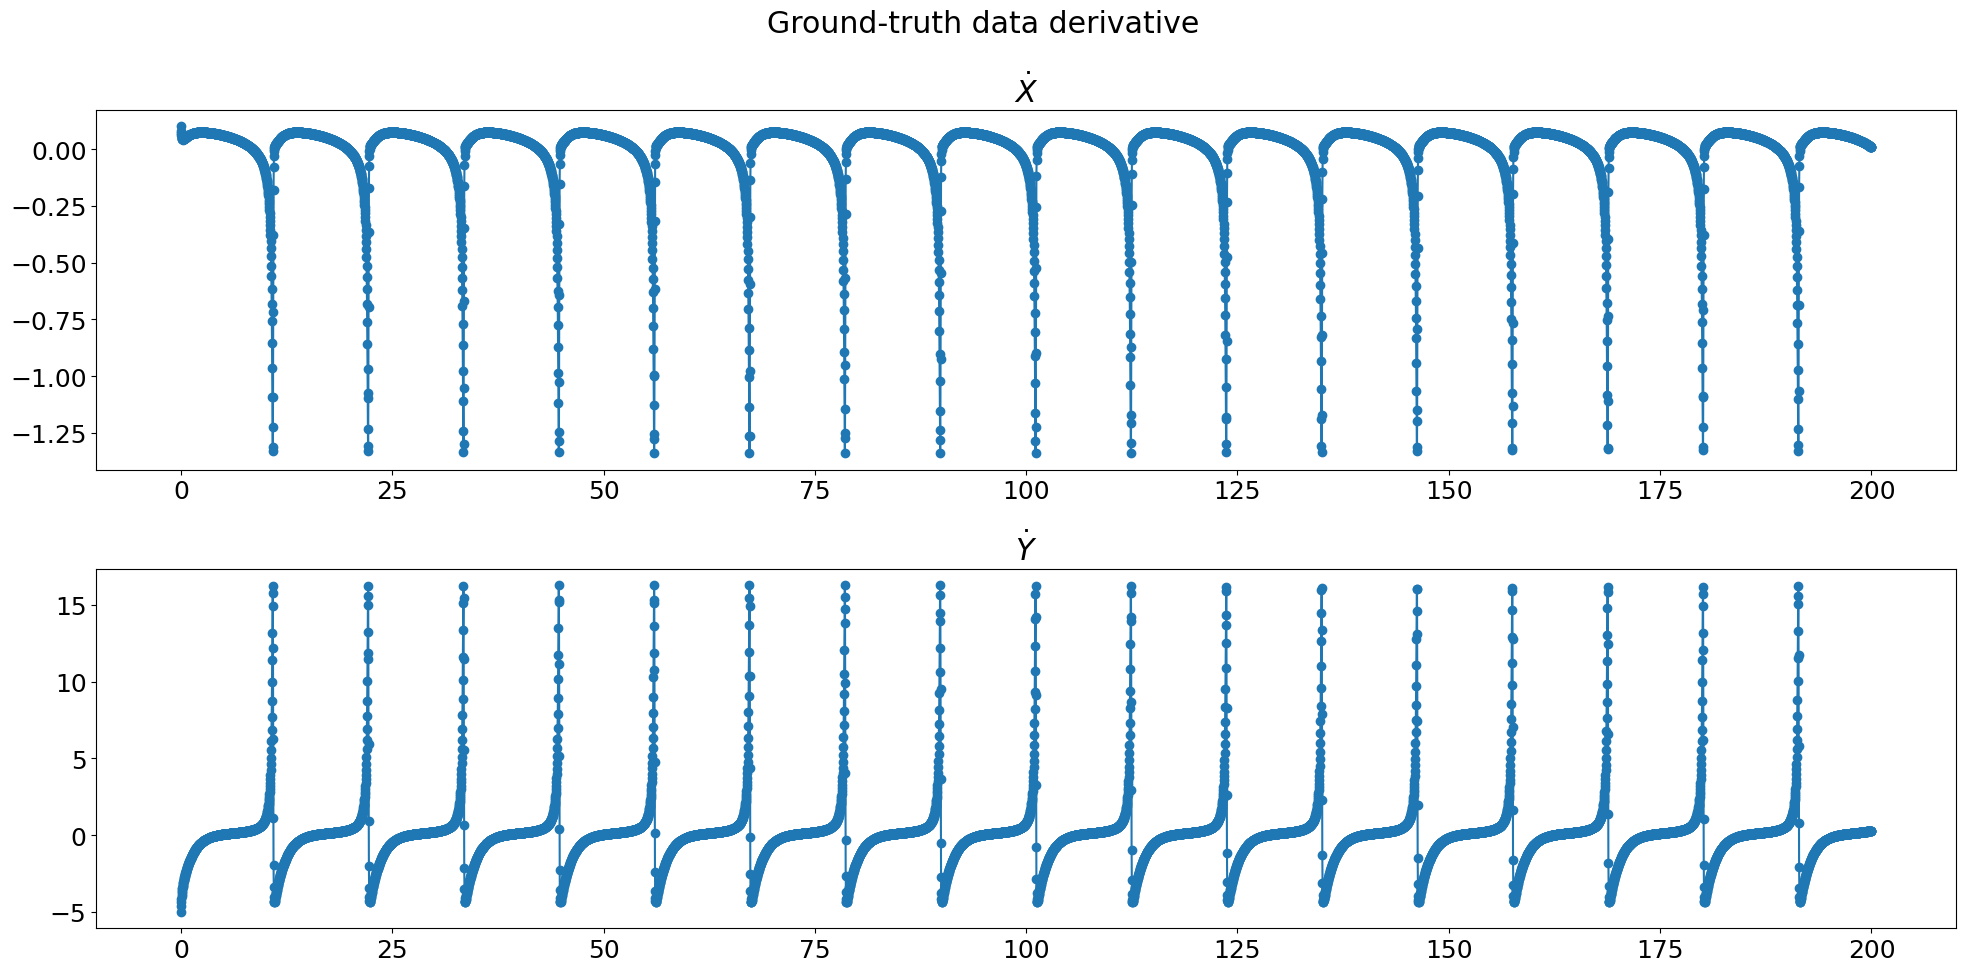

In [4]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes  = 2
x_t      = torch.Tensor(x_t).to(processor)
x        = torch.Tensor(x).to(processor)
y        = torch.Tensor(y).to(processor)
t        = torch.Tensor(t).to(processor)

A_candidates = POOL_DATA (x_t, 2, 1).to(processor)
A1A2_time_deriv = DERIVATIVE (x, y, k, a, b, mu).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
batchsize     = 2048
Epochs        = 10000
learning_rate = 1e-2
step_epoch    = 1200
decay_rate    = 0.50
tolerance     = 5e-3

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 0].detach().cpu().numpy(), '-o')
ax[0].set_title(r"$\dot{X}$")

ax[1].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 1].detach().cpu().numpy(), '-o')
ax[1].set_title(r"$\dot{Y}$")

fig.tight_layout()
plt.show()


In [5]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sin(self.b*x)
        return output

class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

class POWER_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sign(x) * torch.pow(torch.abs(x), self.b)
        return output

class EXP_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.exp(self.b*x)
        return output


In [6]:
class ADAPTIVE_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine, aexp, axsine, axcosine, axexp):
        super().__init__()    
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.aexp     = aexp
        self.axsine   = axsine
        self.axcosine = axcosine
        self.axexp    = axexp
        
        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        self.exp      = EXP_TERM    (self.aexp)
        self.xsine    = SINE_TERM   (self.axsine)
        self.xcosine  = COSINE_TERM (self.axcosine)
        self.xexp     = EXP_TERM    (self.axexp)
        
    def forward(self, x):
        x1             = x [:, 1:]
        output_sine    = self.sine   (x1)
        output_cosine  = self.cosine (x1)
        output_exp     = self.exp    (x1)

        output_xsine   = self.xsine   (x1)
        output_xcosine = self.xcosine (x1)
        output_xexp    = self.xexp    (x1)
 
        output_xsine   = (output_xsine  [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xcosine = (output_xcosine[:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xexp    = (output_xexp   [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        
        output = torch.hstack((x, output_sine, output_cosine, output_exp, output_xsine, output_xcosine, output_xexp)) @ self.a
        return output


In [7]:
# BATCH DATA SPLITTING
train_load    = DataLoader(TensorDataset(A1A2_time_deriv, A_candidates),  batch_size=batchsize, shuffle=True,  drop_last = False)

# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(21, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)

In [8]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, EXP_ADT, XEXP_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1)
Lambda   = Parameter(torch.tensor(1e-3), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)

# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)

**Adaptive SINDy training**

In [9]:
# TEMPORAL MODE 1
A1_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1]).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    loss_epoch = 0.0
    for batch_idx, (A_time_deriv, A_cand) in enumerate(train_load):
        A1_out, A2_out  = A1_DT (A_cand), A2_DT (A_cand)
        output_data  = torch.stack((A1_out , A2_out), dim = 1)
        loss_batch   = loss_function (A_time_deriv, output_data) + (1e-3 + torch.abs(Lambda))*torch.linalg.matrix_norm(COEFF_ADT, ord =1)
    
        optim_COEFF_ADT.zero_grad()
        optim_Lambda.zero_grad()
        optim_weights.zero_grad()
        loss_batch.backward()

        with torch.no_grad():
            optim_COEFF_ADT.step()
            optim_Lambda.step()
            optim_weights.step()
        
            COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
            SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
            COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
            XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
            XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
            EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
            XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
            loss_epoch += loss_batch
    
    N = batch_idx + 1        
    Loss_data [epoch] = (loss_epoch/N).detach()
    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)
       
    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

LOSS DATA, [EPOCH = 0 ]: 144959.796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 75514.0234375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 43102.04296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 26484.931640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 17718.224609375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 12985.25
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 9934.1396484375
LEARNING RATE: 0.01
*********************************************************************

LOSS DATA, [EPOCH = 58 ]: 303.4410705566406
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 59 ]: 291.9734802246094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 60 ]: 279.12896728515625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 61 ]: 267.6661071777344
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 62 ]: 255.72605895996094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 63 ]: 245.97537231445312
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 64 ]: 236.37832641601562
LEARNING RATE: 0.01
********************************

LOSS DATA, [EPOCH = 115 ]: 34.22178268432617
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 116 ]: 33.216224670410156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 117 ]: 32.1473274230957
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 118 ]: 31.19647216796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 119 ]: 30.369165420532227
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 120 ]: 29.45651626586914
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 121 ]: 28.55670166015625
LEARNING RATE: 0.01
****************************

LOSS DATA, [EPOCH = 170 ]: 6.6657633781433105
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 171 ]: 6.440733432769775
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 172 ]: 6.240487575531006
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 173 ]: 6.004158020019531
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 174 ]: 5.7757744789123535
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 175 ]: 5.617356300354004
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 176 ]: 5.449935436248779
LEARNING RATE: 0.01
***************************

LOSS DATA, [EPOCH = 225 ]: 1.8700875043869019
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 226 ]: 1.8616217374801636
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 227 ]: 1.8603134155273438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 228 ]: 1.834804892539978
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 229 ]: 1.7863916158676147
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 230 ]: 1.7615019083023071
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 231 ]: 1.7447680234909058
LEARNING RATE: 0.01
***********************

LOSS DATA, [EPOCH = 283 ]: 0.9215382933616638
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 284 ]: 0.9029706120491028
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 285 ]: 0.8633958697319031
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 286 ]: 0.8557748198509216
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 287 ]: 0.8433892130851746
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 288 ]: 0.8613862991333008
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 289 ]: 0.8529793620109558
LEARNING RATE: 0.01
**********************

LOSS DATA, [EPOCH = 337 ]: 0.4760236442089081
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 338 ]: 0.4801500737667084
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 339 ]: 0.5075110793113708
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 340 ]: 0.4876290261745453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 341 ]: 0.445580393075943
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 342 ]: 0.44347038865089417
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 343 ]: 0.437518447637558
LEARNING RATE: 0.01
***********************

LOSS DATA, [EPOCH = 392 ]: 0.20199596881866455
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 393 ]: 0.2030981034040451
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 394 ]: 0.20843501389026642
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 395 ]: 0.2385619431734085
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 396 ]: 0.24207811057567596
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 397 ]: 0.1941342055797577
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 398 ]: 0.20514057576656342
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 447 ]: 0.11688089370727539
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 448 ]: 0.17039281129837036
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 449 ]: 0.139245867729187
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 450 ]: 0.10547592490911484
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 451 ]: 0.10345850139856339
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 452 ]: 0.09927094727754593
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 453 ]: 0.10293971747159958
LEARNING RATE: 0.01
*****************

LOSS DATA, [EPOCH = 504 ]: 0.07348018884658813
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 505 ]: 0.07662375271320343
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 506 ]: 0.05940181016921997
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 507 ]: 0.05610454082489014
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 508 ]: 0.07503535598516464
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 509 ]: 0.07362204045057297
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 510 ]: 0.05385240912437439
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 558 ]: 0.04233020916581154
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 559 ]: 0.03018328547477722
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 560 ]: 0.031049875542521477
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 561 ]: 0.041235554963350296
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 562 ]: 0.03568725660443306
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 563 ]: 0.025851115584373474
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 564 ]: 0.035188619047403336
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 612 ]: 0.01738155446946621
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 613 ]: 0.022935256361961365
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 614 ]: 0.026753464713692665
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 615 ]: 0.017378829419612885
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 616 ]: 0.01690964214503765
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 617 ]: 0.02236786298453808
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 618 ]: 0.026108650490641594
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 667 ]: 0.010612831450998783
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 668 ]: 0.01299294549971819
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 669 ]: 0.008048963733017445
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 670 ]: 0.007743555586785078
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 671 ]: 0.007001389749348164
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 672 ]: 0.010522079654037952
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 673 ]: 0.011936350725591183
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 722 ]: 0.008611341007053852
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 723 ]: 0.008078510873019695
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 724 ]: 0.008621041662991047
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 725 ]: 0.01060834713280201
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 726 ]: 0.011819349601864815
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 727 ]: 0.007988124154508114
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 728 ]: 0.008198521099984646
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 779 ]: 0.00791902095079422
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 780 ]: 0.0050768740475177765
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 781 ]: 0.0046044099144637585
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 782 ]: 0.007695688400417566
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 783 ]: 0.007545059081166983
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 784 ]: 0.004397870507091284
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 785 ]: 0.0044523561373353004
LEARNING RATE: 0.01
******

LOSS DATA, [EPOCH = 833 ]: 0.0037854649126529694
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 834 ]: 0.003266536397859454
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 835 ]: 0.00470898998901248
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 836 ]: 0.0050210063345730305
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 837 ]: 0.004888985771685839
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 838 ]: 0.00453980965539813
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 839 ]: 0.002884429646655917
LEARNING RATE: 0.01
********

LOSS DATA, [EPOCH = 887 ]: 0.012084420770406723
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 888 ]: 0.010763213969767094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 889 ]: 0.013347516767680645
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 890 ]: 0.01459282822906971
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 891 ]: 0.010321698151528835
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 892 ]: 0.01058347336947918
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 893 ]: 0.014159989543259144
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 941 ]: 0.005084419157356024
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 942 ]: 0.004384161438792944
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 943 ]: 0.005998943466693163
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 944 ]: 0.0066512227058410645
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 945 ]: 0.004233458545058966
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 946 ]: 0.004443430807441473
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 947 ]: 0.006359712686389685
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 995 ]: 0.003750390140339732
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 996 ]: 0.0031623118557035923
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 997 ]: 0.004642833024263382
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 998 ]: 0.005247795954346657
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 999 ]: 0.0033590923994779587
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1000 ]: 0.003540918231010437
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1001 ]: 0.005638760048896074
LEARNING RATE: 0.01
****

LOSS DATA, [EPOCH = 1050 ]: 0.009825453162193298
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1051 ]: 0.009025508537888527
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1052 ]: 0.008998606353998184
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1053 ]: 0.009435039013624191
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1054 ]: 0.009139045141637325
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1055 ]: 0.00818315427750349
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1056 ]: 0.008484047837555408
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1103 ]: 0.005082289222627878
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1104 ]: 0.005632678512483835
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1105 ]: 0.005703283008188009
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1106 ]: 0.00557946041226387
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1107 ]: 0.005304525140672922
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1108 ]: 0.005231446120887995
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1109 ]: 0.005662817042320967
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 1158 ]: 0.005366609897464514
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1159 ]: 0.004997987300157547
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1160 ]: 0.005023449659347534
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1161 ]: 0.005387332756072283
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1162 ]: 0.0053459941409528255
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1163 ]: 0.004661185201257467
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1164 ]: 0.005352653097361326
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 1212 ]: 0.006336107384413481
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1213 ]: 0.005963213741779327
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1214 ]: 0.005991037935018539
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1215 ]: 0.006073059979826212
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1216 ]: 0.00753483921289444
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1217 ]: 0.007959868758916855
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1218 ]: 0.0061512417159974575
LEARNING RATE: 

LOSS DATA, [EPOCH = 1265 ]: 0.0036593563854694366
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1266 ]: 0.003634983440861106
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1267 ]: 0.00365607813000679
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1268 ]: 0.0035360995680093765
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1269 ]: 0.0037068768870085478
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1270 ]: 0.003985052462667227
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1271 ]: 0.005147700663655996
LEARNING RATE

LOSS DATA, [EPOCH = 1321 ]: 0.0037320011761039495
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1322 ]: 0.0032964160200208426
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1323 ]: 0.0024573728442192078
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1324 ]: 0.003388942452147603
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1325 ]: 0.003626409685239196
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1326 ]: 0.0027056585531681776
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1327 ]: 0.0025433192495256662
LEARNING R

LOSS DATA, [EPOCH = 1375 ]: 0.0038415167946368456
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1376 ]: 0.0033639438915997744
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1377 ]: 0.0025043790228664875
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1378 ]: 0.003451431170105934
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1379 ]: 0.0037898197770118713
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1380 ]: 0.002719353185966611
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1381 ]: 0.002598758786916733
LEARNING RA

LOSS DATA, [EPOCH = 1428 ]: 0.003724223468452692
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1429 ]: 0.002727396320551634
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1430 ]: 0.0028258715756237507
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1431 ]: 0.0038770169485360384
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1432 ]: 0.0033873666543513536
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1433 ]: 0.002486028242856264
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1434 ]: 0.003477072808891535
LEARNING RAT

LOSS DATA, [EPOCH = 1483 ]: 0.0027105442713946104
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1484 ]: 0.0028237916994839907
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1485 ]: 0.0038485750555992126
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1486 ]: 0.0033712144941091537
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1487 ]: 0.0024840314872562885
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1488 ]: 0.0034779750276356936
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1489 ]: 0.0037851997185498476
LEARNING

LOSS DATA, [EPOCH = 1538 ]: 0.002510746940970421
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1539 ]: 0.0032624006271362305
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1540 ]: 0.0038702997844666243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1541 ]: 0.0029262062162160873
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1542 ]: 0.0026338468305766582
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1543 ]: 0.0033872846979647875
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1544 ]: 0.0037344228476285934
LEARNING 

LOSS DATA, [EPOCH = 1592 ]: 0.002526658121496439
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1593 ]: 0.0025353189557790756
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1594 ]: 0.0024510789662599564
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1595 ]: 0.0026231305673718452
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1596 ]: 0.002862042048946023
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1597 ]: 0.00382755184546113
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1598 ]: 0.0033995513804256916
LEARNING RAT

LOSS DATA, [EPOCH = 1645 ]: 0.002752862637862563
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1646 ]: 0.0026664864271879196
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1647 ]: 0.0035028874408453703
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1648 ]: 0.004005359020084143
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1649 ]: 0.0030848118476569653
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1650 ]: 0.0026887592393904924
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1651 ]: 0.0026284996420145035
LEARNING R

LOSS DATA, [EPOCH = 1700 ]: 0.0024539008736610413
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1701 ]: 0.0033103451132774353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1702 ]: 0.003816688433289528
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1703 ]: 0.0029750142712146044
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1704 ]: 0.002581944689154625
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1705 ]: 0.0025390605442225933
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1706 ]: 0.003691289573907852
LEARNING RA

LOSS DATA, [EPOCH = 1754 ]: 0.00284312735311687
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1755 ]: 0.0038244181778281927
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1756 ]: 0.0034165021497756243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1757 ]: 0.002439024392515421
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1758 ]: 0.0026565107982605696
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1759 ]: 0.0033919953275471926
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1760 ]: 0.0036881815176457167
LEARNING RA

LOSS DATA, [EPOCH = 1808 ]: 0.0035015770699828863
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1809 ]: 0.003666859120130539
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1810 ]: 0.0027419852558523417
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1811 ]: 0.002582280430942774
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1812 ]: 0.0028461830224841833
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1813 ]: 0.0038505287375301123
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1814 ]: 0.003440394764766097
LEARNING RA

LOSS DATA, [EPOCH = 1863 ]: 0.0036212136037647724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1864 ]: 0.0031738521065562963
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1865 ]: 0.003810348454862833
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1866 ]: 0.0025069417897611856
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1867 ]: 0.0025334872771054506
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1868 ]: 0.002461438300088048
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1869 ]: 0.0032824978698045015
LEARNING R

LOSS DATA, [EPOCH = 1917 ]: 0.0036408042069524527
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1918 ]: 0.0034374557435512543
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1919 ]: 0.0024644231889396906
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1920 ]: 0.00263902242295444
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1921 ]: 0.00347405974753201
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1922 ]: 0.0035858319606631994
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1923 ]: 0.003607124090194702
LEARNING RATE

LOSS DATA, [EPOCH = 1971 ]: 0.002425412181764841
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1972 ]: 0.0026042491663247347
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1973 ]: 0.0024257374461740255
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1974 ]: 0.002601730404421687
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1975 ]: 0.0024246014654636383
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1976 ]: 0.002602599561214447
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 1977 ]: 0.0024224889930337667
LEARNING RA

LOSS DATA, [EPOCH = 2025 ]: 0.0036236203741282225
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2026 ]: 0.003424741793423891
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2027 ]: 0.002449809340760112
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2028 ]: 0.0026241622399538755
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2029 ]: 0.0034817957784980536
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2030 ]: 0.0035724067129194736
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2031 ]: 0.003619705094024539
LEARNING RA

LOSS DATA, [EPOCH = 2079 ]: 0.002413193928077817
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2080 ]: 0.0026092480402439833
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2081 ]: 0.002414517570286989
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2082 ]: 0.002614470897242427
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2083 ]: 0.002432113280519843
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2084 ]: 0.0026393968146294355
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2085 ]: 0.002442009514197707
LEARNING RATE

LOSS DATA, [EPOCH = 2132 ]: 0.0026240921579301357
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2133 ]: 0.0034774483647197485
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2134 ]: 0.0035692439414560795
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2135 ]: 0.0036075077950954437
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2136 ]: 0.003416425781324506
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2137 ]: 0.0024491604417562485
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2138 ]: 0.0026329108513891697
LEARNING 

LOSS DATA, [EPOCH = 2187 ]: 0.002430543303489685
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2188 ]: 0.002590123564004898
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2189 ]: 0.0024340518284589052
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2190 ]: 0.002590734511613846
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2191 ]: 0.0024337691720575094
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2192 ]: 0.0025964134838432074
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2193 ]: 0.0024330993182957172
LEARNING RA

LOSS DATA, [EPOCH = 2242 ]: 0.002586007583886385
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2243 ]: 0.002433081855997443
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2244 ]: 0.002589423907920718
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2245 ]: 0.0024385121650993824
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2246 ]: 0.0025938311591744423
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2247 ]: 0.002479016548022628
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2248 ]: 0.0037784376181662083
LEARNING RAT

LOSS DATA, [EPOCH = 2296 ]: 0.002523045754060149
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2297 ]: 0.0024987664073705673
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2298 ]: 0.002529068849980831
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2299 ]: 0.002505261218175292
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2300 ]: 0.0025242778938263655
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2301 ]: 0.002498385962098837
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2302 ]: 0.0025253130588680506
LEARNING RAT

LOSS DATA, [EPOCH = 2349 ]: 0.002413933863863349
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2350 ]: 0.0025754806119948626
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2351 ]: 0.002454234752804041
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2352 ]: 0.002514461288228631
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2353 ]: 0.0025072151329368353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2354 ]: 0.0024322543758898973
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2355 ]: 0.002592454431578517
LEARNING RAT

LOSS DATA, [EPOCH = 2404 ]: 0.0028051293920725584
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2405 ]: 0.0028118721675127745
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2406 ]: 0.0027882151771336794
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2407 ]: 0.002761663170531392
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2408 ]: 0.0026794103905558586
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2409 ]: 0.0028595502953976393
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2410 ]: 0.002836646046489477
LEAR

LOSS DATA, [EPOCH = 2458 ]: 0.0028303556609898806
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2459 ]: 0.0026406431570649147
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2460 ]: 0.0028013638220727444
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2461 ]: 0.0028167746495455503
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2462 ]: 0.0027994976844638586
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2463 ]: 0.0027488982304930687
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2464 ]: 0.0026991076301783323
LE

LOSS DATA, [EPOCH = 2510 ]: 0.0027935358230024576
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2511 ]: 0.0027442469727247953
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2512 ]: 0.0026932440232485533
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2513 ]: 0.0028491748962551355
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2514 ]: 0.002827256917953491
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2515 ]: 0.0026394270826131105
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2516 ]: 0.0028019214514642954
LEA

LOSS DATA, [EPOCH = 2563 ]: 0.0026603739243000746
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2564 ]: 0.002778710564598441
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2565 ]: 0.0028238212689757347
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2566 ]: 0.0028015042189508677
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2567 ]: 0.0027257075998932123
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2568 ]: 0.0027189876418560743
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2569 ]: 0.0028432775288820267
LEA

LOSS DATA, [EPOCH = 2616 ]: 0.0027205629739910364
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2617 ]: 0.002843716414645314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2618 ]: 0.0028191767632961273
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2619 ]: 0.0026633183006197214
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2620 ]: 0.002772032981738448
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2621 ]: 0.002822150941938162
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2622 ]: 0.0028026404324918985
LEARN

LOSS DATA, [EPOCH = 2670 ]: 0.0028087717946618795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2671 ]: 0.002711169421672821
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2672 ]: 0.0027281136717647314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2673 ]: 0.002839301247149706
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2674 ]: 0.0028179865330457687
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2675 ]: 0.0026804457884281874
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2676 ]: 0.0027672366704791784
LEAR

LOSS DATA, [EPOCH = 2724 ]: 0.0027618834283202887
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2725 ]: 0.0028261810075491667
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2726 ]: 0.0028040134347975254
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2727 ]: 0.0027090772055089474
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2728 ]: 0.0027288016863167286
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2729 ]: 0.002837101463228464
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2730 ]: 0.0028141923248767853
LEA

LOSS DATA, [EPOCH = 2778 ]: 0.0028166917618364096
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2779 ]: 0.0026738992892205715
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2780 ]: 0.002767235739156604
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2781 ]: 0.0028240943793207407
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2782 ]: 0.0028037906158715487
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2783 ]: 0.0027101009618490934
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2784 ]: 0.002731925342231989
LEAR

LOSS DATA, [EPOCH = 2832 ]: 0.0027314089238643646
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2833 ]: 0.0028370514046400785
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2834 ]: 0.0028141194488853216
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2835 ]: 0.0026790460105985403
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2836 ]: 0.0027576873544603586
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2837 ]: 0.002829852281138301
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2838 ]: 0.0028064872603863478
LEA

LOSS DATA, [EPOCH = 2888 ]: 0.002739580115303397
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2889 ]: 0.002833490027114749
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2890 ]: 0.002810858888551593
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2891 ]: 0.0026863161474466324
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2892 ]: 0.0027495145332068205
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2893 ]: 0.0028307195752859116
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2894 ]: 0.0028095447923988104
LEARN

LOSS DATA, [EPOCH = 2941 ]: 0.0028301135171204805
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2942 ]: 0.002807319164276123
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2943 ]: 0.002698367927223444
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2944 ]: 0.002738417824730277
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2945 ]: 0.0028350267093628645
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2946 ]: 0.002814218867570162
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2947 ]: 0.0026878684293478727
LEARNI

LOSS DATA, [EPOCH = 2995 ]: 0.0026941602118313313
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2996 ]: 0.0027561632450670004
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2997 ]: 0.002832614118233323
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2998 ]: 0.0028117599431425333
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 2999 ]: 0.002702082972973585
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3000 ]: 0.0027420111000537872
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3001 ]: 0.002836998552083969
LEARN

LOSS DATA, [EPOCH = 3050 ]: 0.0028129983693361282
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3051 ]: 0.0026834525633603334
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3052 ]: 0.0027522805612534285
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3053 ]: 0.0028289530891925097
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3054 ]: 0.002807996002957225
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3055 ]: 0.0026992091443389654
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3056 ]: 0.0027364513371139765
LEA

LOSS DATA, [EPOCH = 3104 ]: 0.0027418010868132114
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3105 ]: 0.0028332192450761795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3106 ]: 0.0028111606370657682
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3107 ]: 0.002690001158043742
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3108 ]: 0.0027504449244588614
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3109 ]: 0.0028304574079811573
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3110 ]: 0.0028103950899094343
LEA

LOSS DATA, [EPOCH = 3158 ]: 0.002808606717735529
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3159 ]: 0.0026965008582919836
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3160 ]: 0.0027397789526730776
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3161 ]: 0.0028330516070127487
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3162 ]: 0.0028112309519201517
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3163 ]: 0.0026850306894630194
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3164 ]: 0.002749784616753459
LEAR

LOSS DATA, [EPOCH = 3213 ]: 0.0028297097887843847
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3214 ]: 0.002807278884574771
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3215 ]: 0.0027026182506233454
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3216 ]: 0.002736668800935149
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3217 ]: 0.0028343708254396915
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3218 ]: 0.0028108840342611074
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3219 ]: 0.002685846760869026
LEARN

LOSS DATA, [EPOCH = 3266 ]: 0.002810093807056546
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3267 ]: 0.002688479144126177
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3268 ]: 0.002748365281149745
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3269 ]: 0.00283042062073946
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3270 ]: 0.00280717178247869
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3271 ]: 0.002694950206205249
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3272 ]: 0.002740192925557494
LEARNING RA

LOSS DATA, [EPOCH = 3321 ]: 0.002845366718247533
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3322 ]: 0.002825565868988633
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3323 ]: 0.0027014324441552162
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3324 ]: 0.0027508377097547054
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3325 ]: 0.0028355654794722795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3326 ]: 0.002814844949170947
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3327 ]: 0.0026900700759142637
LEARN

LOSS DATA, [EPOCH = 3375 ]: 0.002696879440918565
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3376 ]: 0.002742075128480792
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3377 ]: 0.002833721926435828
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3378 ]: 0.002814030973240733
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3379 ]: 0.002687569009140134
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3380 ]: 0.0027561993338167667
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3381 ]: 0.002829297911375761
LEARNING

LOSS DATA, [EPOCH = 3429 ]: 0.002829986158758402
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3430 ]: 0.0028094870503991842
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3431 ]: 0.002691438887268305
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3432 ]: 0.0027443617582321167
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3433 ]: 0.002831987338140607
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3434 ]: 0.0028083252254873514
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3435 ]: 0.002695290604606271
LEARNI

LOSS DATA, [EPOCH = 3483 ]: 0.002691950649023056
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3484 ]: 0.00275276112370193
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3485 ]: 0.0028341752476990223
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3486 ]: 0.0028088900726288557
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3487 ]: 0.0026925094425678253
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3488 ]: 0.002744299592450261
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3489 ]: 0.002833671635016799
LEARNIN

LOSS DATA, [EPOCH = 3538 ]: 0.0028125077951699495
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3539 ]: 0.002686183899641037
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3540 ]: 0.00274963048286736
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3541 ]: 0.0028306522872298956
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3542 ]: 0.00280999974347651
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3543 ]: 0.0027008613105863333
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3544 ]: 0.002741620410233736
LEARNING

LOSS DATA, [EPOCH = 3591 ]: 0.00268952245824039
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3592 ]: 0.002747765276581049
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3593 ]: 0.002831976395100355
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3594 ]: 0.002809630474075675
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3595 ]: 0.0026983991265296936
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3596 ]: 0.0027450111228972673
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 3597 ]: 0.0028340350836515427
LEARNIN

LOSS DATA, [EPOCH = 3646 ]: 0.0024292967282235622
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3647 ]: 0.002408558502793312
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3648 ]: 0.002457001246511936
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3649 ]: 0.002218361711129546
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3650 ]: 0.002141545293852687
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3651 ]: 0.002104185987263918
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3652 ]: 0.002151690423488617
LE

LOSS DATA, [EPOCH = 3700 ]: 0.0021218573674559593
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3701 ]: 0.0021266676485538483
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3702 ]: 0.00210990640334785
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3703 ]: 0.002314707264304161
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3704 ]: 0.0024446563329547644
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3705 ]: 0.0022436294239014387
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3706 ]: 0.0024900748394429684

LOSS DATA, [EPOCH = 3754 ]: 0.0024292345624417067
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3755 ]: 0.0024071151856333017
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3756 ]: 0.002457123249769211
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3757 ]: 0.0022190199233591557
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3758 ]: 0.0021415632218122482
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3759 ]: 0.002104504033923149
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3760 ]: 0.002149709267541766

LOSS DATA, [EPOCH = 3808 ]: 0.002121688099578023
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3809 ]: 0.0021269596181809902
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3810 ]: 0.002111317589879036
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3811 ]: 0.002314344746991992
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3812 ]: 0.002444419777020812
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3813 ]: 0.002246512332931161
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3814 ]: 0.002486414974555373
LE

LOSS DATA, [EPOCH = 3862 ]: 0.002432909794151783
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3863 ]: 0.002405799925327301
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3864 ]: 0.0024555015843361616
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3865 ]: 0.0022201710380613804
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3866 ]: 0.0021412589121609926
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3867 ]: 0.00210695737041533
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3868 ]: 0.002149048959836364
L

LOSS DATA, [EPOCH = 3917 ]: 0.00213893735781312
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3918 ]: 0.002373047871515155
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3919 ]: 0.002399138640612364
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3920 ]: 0.0022870777174830437
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3921 ]: 0.0024467126931995153
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3922 ]: 0.002121698809787631
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3923 ]: 0.0021382819395512342
L

LOSS DATA, [EPOCH = 3971 ]: 0.00216327584348619
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3972 ]: 0.0021018546540290117
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3973 ]: 0.0023233683314174414
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3974 ]: 0.0024435673840343952
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3975 ]: 0.0022442606277763844
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3976 ]: 0.0024875784292817116
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 3977 ]: 0.002163621829822659

LOSS DATA, [EPOCH = 4025 ]: 0.002164846519008279
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4026 ]: 0.0021035403478890657
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4027 ]: 0.0023229471407830715
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4028 ]: 0.0024430868215858936
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4029 ]: 0.0022463921923190355
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4030 ]: 0.002485655015334487
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4031 ]: 0.002164821838960051

LOSS DATA, [EPOCH = 4079 ]: 0.00216491031460464
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4080 ]: 0.0021035566460341215
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4081 ]: 0.0023223559837788343
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4082 ]: 0.0024427275639027357
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4083 ]: 0.002249138429760933
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4084 ]: 0.002484075026586652
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4085 ]: 0.0021669287234544754


LOSS DATA, [EPOCH = 4132 ]: 0.0024814745411276817
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4133 ]: 0.0021655866876244545
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4134 ]: 0.0021046088077127934
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4135 ]: 0.002321288688108325
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4136 ]: 0.0024417126551270485
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4137 ]: 0.002251384546980262
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4138 ]: 0.002483623567968607

LOSS DATA, [EPOCH = 4185 ]: 0.0022528653498739004
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4186 ]: 0.0024802011903375387
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4187 ]: 0.0021666025277227163
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4188 ]: 0.0021050868090242147
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4189 ]: 0.002321033738553524
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4190 ]: 0.002442887518554926
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4191 ]: 0.002252026926726103

LOSS DATA, [EPOCH = 4237 ]: 0.0023207422345876694
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4238 ]: 0.002440290292724967
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4239 ]: 0.0022537929471582174
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4240 ]: 0.002478055190294981
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4241 ]: 0.002166384132578969
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4242 ]: 0.0021052237134426832
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4243 ]: 0.0023199410643428564

LOSS DATA, [EPOCH = 4291 ]: 0.0023207685444504023
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4292 ]: 0.00244126096367836
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4293 ]: 0.002253105165436864
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4294 ]: 0.002478931797668338
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4295 ]: 0.002166822785511613
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4296 ]: 0.0021052078809589148
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4297 ]: 0.002320848172530532
LE

LOSS DATA, [EPOCH = 4345 ]: 0.002321594161912799
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4346 ]: 0.002441482385620475
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4347 ]: 0.002252304693683982
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4348 ]: 0.0024803474079817533
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4349 ]: 0.0021666677203029394
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4350 ]: 0.0021061899606138468
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4351 ]: 0.002321715233847499


LOSS DATA, [EPOCH = 4399 ]: 0.0023213806562125683
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4400 ]: 0.0024411811027675867
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4401 ]: 0.0022516779135912657
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4402 ]: 0.002480131108313799
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4403 ]: 0.002165710087865591
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4404 ]: 0.0021047291811555624
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4405 ]: 0.002320759231224656

LOSS DATA, [EPOCH = 4454 ]: 0.0024403731804341078
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4455 ]: 0.0022531787399202585
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4456 ]: 0.0024781825486570597
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4457 ]: 0.0021661121863871813
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4458 ]: 0.0021049424540251493
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4459 ]: 0.002320756670087576
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4460 ]: 0.00244046305306255

LOSS DATA, [EPOCH = 4508 ]: 0.0024421631824225187
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4509 ]: 0.0022520606871694326
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4510 ]: 0.0024800098035484552
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4511 ]: 0.0021661773789674044
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4512 ]: 0.002104365499690175
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4513 ]: 0.0023206055629998446
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4514 ]: 0.00244123162701725

LOSS DATA, [EPOCH = 4562 ]: 0.002442503347992897
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4563 ]: 0.00224942690692842
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4564 ]: 0.002481685718521476
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4565 ]: 0.00216530729085207
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4566 ]: 0.002103668637573719
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4567 ]: 0.0023211243096739054
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4568 ]: 0.002441858872771263
LEAR

LOSS DATA, [EPOCH = 4614 ]: 0.002105899853631854
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4615 ]: 0.002321518026292324
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4616 ]: 0.002441470278427005
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4617 ]: 0.0022497898899018764
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4618 ]: 0.0024824587162584066
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4619 ]: 0.0021660614293068647
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4620 ]: 0.0021062097512185574

LOSS DATA, [EPOCH = 4667 ]: 0.0021666204556822777
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4668 ]: 0.002103980863466859
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4669 ]: 0.0023216709960252047
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4670 ]: 0.0024422365240752697
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4671 ]: 0.0022527449764311314
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4672 ]: 0.0024865164887160063
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4673 ]: 0.00216725189238786

LOSS DATA, [EPOCH = 4720 ]: 0.0024802626576274633
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4721 ]: 0.002165688667446375
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4722 ]: 0.002106039086356759
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4723 ]: 0.0023218942806124687
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4724 ]: 0.0024415533989667892
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4725 ]: 0.0022514164447784424
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4726 ]: 0.002480131341144442

LOSS DATA, [EPOCH = 4772 ]: 0.002441379241645336
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4773 ]: 0.0022520439233630896
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4774 ]: 0.0024801830295473337
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4775 ]: 0.002165892394259572
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4776 ]: 0.0021044407039880753
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4777 ]: 0.0023205073084682226
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 4778 ]: 0.00244158785790205


LOSS DATA, [EPOCH = 4824 ]: 0.0022392647806555033
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4825 ]: 0.002186055527999997
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4826 ]: 0.00218187621794641
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4827 ]: 0.002226652344688773
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4828 ]: 0.0021289277356117964
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4829 ]: 0.002224375493824482
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4830 ]: 0.002218427136540

LOSS DATA, [EPOCH = 4876 ]: 0.002127201994881034
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4877 ]: 0.0022240744438022375
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4878 ]: 0.0022176839411258698
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4879 ]: 0.002113624243065715
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4880 ]: 0.0022386005148291588
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4881 ]: 0.0021860578563064337
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4882 ]: 0.002180809853

LOSS DATA, [EPOCH = 4928 ]: 0.002237006789073348
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4929 ]: 0.00218646670691669
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4930 ]: 0.002181092044338584
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4931 ]: 0.002223711460828781
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4932 ]: 0.0021289121359586716
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4933 ]: 0.0022227943409234285
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4934 ]: 0.002217334462329

LOSS DATA, [EPOCH = 4983 ]: 0.0021170189138501883
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4984 ]: 0.002235530875623226
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4985 ]: 0.0021885866299271584
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4986 ]: 0.0021826622541993856
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4987 ]: 0.0022225817665457726
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4988 ]: 0.0021322262473404408
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 4989 ]: 0.00222256779

LOSS DATA, [EPOCH = 5037 ]: 0.002221594797447324
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5038 ]: 0.0022162259556353092
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5039 ]: 0.0021186363883316517
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5040 ]: 0.002234312007203698
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5041 ]: 0.002187721198424697
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5042 ]: 0.002182070864364505
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5043 ]: 0.00222048792056

LOSS DATA, [EPOCH = 5092 ]: 0.002133101923391223
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5093 ]: 0.0022215116769075394
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5094 ]: 0.0022159141954034567
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5095 ]: 0.002119347918778658
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5096 ]: 0.002233013277873397
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5097 ]: 0.002188157057389617
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5098 ]: 0.00218261568807

LOSS DATA, [EPOCH = 5146 ]: 0.0021830685436725616
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5147 ]: 0.002218992216512561
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5148 ]: 0.0021334406919777393
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5149 ]: 0.002220900496467948
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5150 ]: 0.0022157353814691305
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5151 ]: 0.0021199050825089216
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5152 ]: 0.002232514088

LOSS DATA, [EPOCH = 5199 ]: 0.0021207768004387617
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5200 ]: 0.0022318013943731785
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5201 ]: 0.0021881149150431156
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5202 ]: 0.0021833593491464853
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5203 ]: 0.0022185209672898054
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5204 ]: 0.0021349380258470774
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5205 ]: 0.0022208157

LOSS DATA, [EPOCH = 5251 ]: 0.002217258093878627
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5252 ]: 0.0021352979820221663
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5253 ]: 0.0022205885034054518
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5254 ]: 0.0022153945174068213
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5255 ]: 0.002122725360095501
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5256 ]: 0.0022329867351800203
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5257 ]: 0.002189249265

LOSS DATA, [EPOCH = 5303 ]: 0.002122972859069705
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5304 ]: 0.0022308879997581244
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5305 ]: 0.002189250197261572
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5306 ]: 0.002183818956837058
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5307 ]: 0.0022168243303894997
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5308 ]: 0.002135785296559334
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5309 ]: 0.00222034100443

LOSS DATA, [EPOCH = 5355 ]: 0.002216512570157647
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5356 ]: 0.0021368854213505983
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5357 ]: 0.0022199146915227175
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5358 ]: 0.0022145425900816917
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5359 ]: 0.0021238704212009907
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5360 ]: 0.0022297061514109373
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5361 ]: 0.00218911003

LOSS DATA, [EPOCH = 5407 ]: 0.002123665064573288
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5408 ]: 0.0022285582963377237
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5409 ]: 0.0021897510159760714
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5410 ]: 0.0021839942783117294
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5411 ]: 0.0022147800773382187
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5412 ]: 0.002137175528332591
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5413 ]: 0.002219546819

LOSS DATA, [EPOCH = 5460 ]: 0.0021387706510722637
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5461 ]: 0.00222045392729342
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5462 ]: 0.002215492306277156
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5463 ]: 0.0021266720723360777
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5464 ]: 0.0022277715615928173
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5465 ]: 0.00218956358730793
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5466 ]: 0.002184179378673

LOSS DATA, [EPOCH = 5513 ]: 0.002190450904890895
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5514 ]: 0.0021845868322998285
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5515 ]: 0.00221260916441679
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5516 ]: 0.002139562740921974
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5517 ]: 0.002218895126134157
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5518 ]: 0.0022136594634503126
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5519 ]: 0.002125928876921

LOSS DATA, [EPOCH = 5567 ]: 0.002127359388396144
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5568 ]: 0.002226992277428508
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5569 ]: 0.002191874198615551
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5570 ]: 0.002185106510296464
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5571 ]: 0.002211353974416852
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5572 ]: 0.0021406577434390783
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5573 ]: 0.002218718407675

LOSS DATA, [EPOCH = 5620 ]: 0.0021420044358819723
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5621 ]: 0.0022186674177646637
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5622 ]: 0.002212963765487075
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5623 ]: 0.002127923769876361
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5624 ]: 0.0022242902778089046
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5625 ]: 0.0021905931644141674
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5626 ]: 0.002185431076

LOSS DATA, [EPOCH = 5675 ]: 0.00221128948032856
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5676 ]: 0.002142426325008273
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5677 ]: 0.0022191999014467
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5678 ]: 0.0022135626059025526
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5679 ]: 0.002128641353920102
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5680 ]: 0.002224421827122569
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5681 ]: 0.002190589439123869

LOSS DATA, [EPOCH = 5728 ]: 0.0022232148330658674
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5729 ]: 0.002191194100305438
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5730 ]: 0.002186090685427189
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5731 ]: 0.0022093639709055424
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5732 ]: 0.0021426521707326174
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5733 ]: 0.0022178988438099623
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5734 ]: 0.002212490886

LOSS DATA, [EPOCH = 5780 ]: 0.002143456833437085
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5781 ]: 0.0022175165358930826
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5782 ]: 0.002212200313806534
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5783 ]: 0.0021296008490025997
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5784 ]: 0.0022227212321013212
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5785 ]: 0.0021915503311902285
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5786 ]: 0.002186041325

LOSS DATA, [EPOCH = 5833 ]: 0.0021913289092481136
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5834 ]: 0.002185945399105549
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5835 ]: 0.002208851044997573
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5836 ]: 0.002143264515325427
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5837 ]: 0.0022174848709255457
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5838 ]: 0.0022120755165815353
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5839 ]: 0.0021299363579

LOSS DATA, [EPOCH = 5885 ]: 0.00221774959936738
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5886 ]: 0.0022121293004602194
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5887 ]: 0.0021313901524990797
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5888 ]: 0.002221503993496299
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5889 ]: 0.00219190726056695
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5890 ]: 0.002186752390116453
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5891 ]: 0.0022084512747824

LOSS DATA, [EPOCH = 5938 ]: 0.0021872937213629484
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5939 ]: 0.0022082854993641376
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5940 ]: 0.0021450768690556288
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5941 ]: 0.0022169926669448614
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5942 ]: 0.0022118950728327036
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5943 ]: 0.0021319452207535505
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5944 ]: 0.0022214432

LOSS DATA, [EPOCH = 5991 ]: 0.002132534282281995
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5992 ]: 0.0022194727789610624
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5993 ]: 0.0021921421866863966
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5994 ]: 0.0021868485491722822
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5995 ]: 0.002205859636887908
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5996 ]: 0.0021463020239025354
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 5997 ]: 0.002216749591

LOSS DATA, [EPOCH = 6043 ]: 0.002047441666945815
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6044 ]: 0.0020196340046823025
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6045 ]: 0.0020707151852548122
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6046 ]: 0.0021182429045438766
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6047 ]: 0.0020466342102736235
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6048 ]: 0.002080985577777028
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6049 ]: 0.002116

LOSS DATA, [EPOCH = 6096 ]: 0.0020987344905734062
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6097 ]: 0.0021021056454628706
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6098 ]: 0.0020248570945113897
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6099 ]: 0.002034715609624982
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6100 ]: 0.0020920480601489544
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6101 ]: 0.002103576436638832
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6102 ]: 0.002044

LOSS DATA, [EPOCH = 6149 ]: 0.0020465615671128035
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6150 ]: 0.002080794656649232
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6151 ]: 0.0021167814265936613
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6152 ]: 0.0020358094479888678
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6153 ]: 0.0020761971827596426
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6154 ]: 0.0021128260996192694
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6155 ]: 0.00203

LOSS DATA, [EPOCH = 6201 ]: 0.00207616132684052
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6202 ]: 0.002112875459715724
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6203 ]: 0.0020337128080427647
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6204 ]: 0.0020348860416561365
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6205 ]: 0.0020698450971394777
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6206 ]: 0.0021175413858145475
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6207 ]: 0.0020340

LOSS DATA, [EPOCH = 6254 ]: 0.0021176605951040983
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6255 ]: 0.0020345915108919144
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6256 ]: 0.0020971940830349922
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6257 ]: 0.0021022383589297533
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6258 ]: 0.0020445140544325113
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6259 ]: 0.002112369751557708
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6260 ]: 0.00207

LOSS DATA, [EPOCH = 6307 ]: 0.002033808035776019
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6308 ]: 0.0020349042024463415
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6309 ]: 0.0020701598841696978
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6310 ]: 0.002117294119670987
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6311 ]: 0.0020338573958724737
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6312 ]: 0.002097352175042033
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6313 ]: 0.0021021

LOSS DATA, [EPOCH = 6359 ]: 0.002066886518150568
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6360 ]: 0.0021184650249779224
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6361 ]: 0.0020480635575950146
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6362 ]: 0.0020195588003844023
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6363 ]: 0.0020710460375994444
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6364 ]: 0.0021183700300753117
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6365 ]: 0.00204

LOSS DATA, [EPOCH = 6412 ]: 0.0020447138231247663
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6413 ]: 0.0021117019932717085
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6414 ]: 0.002074149902909994
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6415 ]: 0.002024601912125945
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6416 ]: 0.002047219080850482
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6417 ]: 0.0021092116367071867
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6418 ]: 0.0020734

LOSS DATA, [EPOCH = 6464 ]: 0.0020249553490430117
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6465 ]: 0.0020349398255348206
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6466 ]: 0.002091562608256936
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6467 ]: 0.0021038514096289873
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6468 ]: 0.0020447715651243925
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6469 ]: 0.002111717825755477
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6470 ]: 0.002073

LOSS DATA, [EPOCH = 6517 ]: 0.0020341218914836645
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6518 ]: 0.0020986346062272787
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6519 ]: 0.002101858612149954
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6520 ]: 0.0020253330003470182
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6521 ]: 0.002035037847235799
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6522 ]: 0.0020915556233376265
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6523 ]: 0.002103

LOSS DATA, [EPOCH = 6570 ]: 0.002097659045830369
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6571 ]: 0.002102118683978915
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6572 ]: 0.002025255002081394
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6573 ]: 0.002035168930888176
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6574 ]: 0.002091858070343733
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6575 ]: 0.002103699604049325
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6576 ]: 0.0020445634

LOSS DATA, [EPOCH = 6622 ]: 0.0021186391822993755
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6623 ]: 0.0020465627312660217
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6624 ]: 0.002080989070236683
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6625 ]: 0.002116486430168152
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6626 ]: 0.0020360115449875593
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6627 ]: 0.002021472668275237
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6628 ]: 0.0020805

LOSS DATA, [EPOCH = 6675 ]: 0.0020348753314465284
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6676 ]: 0.002091406611725688
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6677 ]: 0.0021038465201854706
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6678 ]: 0.0020448872819542885
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6679 ]: 0.0021119040902704
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6680 ]: 0.002074067248031497
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6681 ]: 0.002024737

LOSS DATA, [EPOCH = 6728 ]: 0.002035995712503791
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6729 ]: 0.0020212093368172646
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6730 ]: 0.0020802475046366453
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6731 ]: 0.0021193111315369606
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6732 ]: 0.0020348161924630404
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6733 ]: 0.002076004398986697
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6734 ]: 0.002112

LOSS DATA, [EPOCH = 6780 ]: 0.0020447829738259315
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6781 ]: 0.0021118810400366783
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6782 ]: 0.0020740353502333164
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6783 ]: 0.0020244084298610687
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6784 ]: 0.0020473957993090153
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6785 ]: 0.002109766472131014
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6786 ]: 0.00207

LOSS DATA, [EPOCH = 6833 ]: 0.0021199919283390045
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6834 ]: 0.002035215264186263
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6835 ]: 0.0020768512040376663
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6836 ]: 0.002113594440743327
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6837 ]: 0.002034279517829418
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6838 ]: 0.0020347812678664923
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6839 ]: 0.0020709

LOSS DATA, [EPOCH = 6885 ]: 0.002024397486820817
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6886 ]: 0.002047201618552208
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6887 ]: 0.0021091594826430082
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6888 ]: 0.0020735410507768393
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6889 ]: 0.0020672143436968327
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6890 ]: 0.0021187602542340755
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6891 ]: 0.002048

LOSS DATA, [EPOCH = 6938 ]: 0.002113454509526491
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6939 ]: 0.002034044824540615
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6940 ]: 0.002034755889326334
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6941 ]: 0.002070659538730979
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6942 ]: 0.0021166845690459013
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6943 ]: 0.002033653436228633
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6944 ]: 0.002097949

LOSS DATA, [EPOCH = 6991 ]: 0.0020666199270635843
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6992 ]: 0.0021177807357162237
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6993 ]: 0.002047630725428462
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6994 ]: 0.0020195944234728813
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6995 ]: 0.002070570131763816
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6996 ]: 0.002118076430633664
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 6997 ]: 0.0020467

LOSS DATA, [EPOCH = 7043 ]: 0.002070862799882889
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7044 ]: 0.0021176994778215885
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7045 ]: 0.002033980330452323
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7046 ]: 0.0020975021179765463
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7047 ]: 0.0021019906271249056
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7048 ]: 0.002025033114477992
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7049 ]: 0.0020350

LOSS DATA, [EPOCH = 7096 ]: 0.0020197753328830004
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7097 ]: 0.00207131146453321
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7098 ]: 0.0021183204371482134
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7099 ]: 0.0020466726273298264
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7100 ]: 0.0020810691639781
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7101 ]: 0.002116471529006958
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7102 ]: 0.0020360392

LOSS DATA, [EPOCH = 7149 ]: 0.002102126134559512
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7150 ]: 0.0020252398680895567
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7151 ]: 0.0020352343562990427
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7152 ]: 0.0020915467757731676
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7153 ]: 0.0021038586273789406
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7154 ]: 0.002044674474745989
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 7155 ]: 0.002111

LOSS DATA, [EPOCH = 7201 ]: 0.0020380550995469093
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7202 ]: 0.002048236085101962
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7203 ]: 0.0020350583363324404
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7204 ]: 0.0020476875361055136
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7205 ]: 0.002045690780505538
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7206 ]: 0.002042809734120965
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7207 ]: 0.0

LOSS DATA, [EPOCH = 7254 ]: 0.0020426176488399506
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7255 ]: 0.002050247974693775
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7256 ]: 0.0020310101099312305
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7257 ]: 0.002051505958661437
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7258 ]: 0.0020501799881458282
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7259 ]: 0.002027645707130432
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7260 ]: 0.0

LOSS DATA, [EPOCH = 7307 ]: 0.0020275646820664406
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7308 ]: 0.0020535686053335667
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7309 ]: 0.0020439911168068647
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7310 ]: 0.0020426136907190084
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7311 ]: 0.0020501194521784782
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7312 ]: 0.0020310324616730213
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7313 ]: 

LOSS DATA, [EPOCH = 7359 ]: 0.0020500568207353354
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7360 ]: 0.0020310531836003065
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7361 ]: 0.0020514170173555613
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7362 ]: 0.002050126204267144
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7363 ]: 0.0020277209114283323
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7364 ]: 0.002053482225164771
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7365 ]: 0.

LOSS DATA, [EPOCH = 7412 ]: 0.0020534039940685034
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7413 ]: 0.0020440961234271526
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7414 ]: 0.0020425727125257254
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7415 ]: 0.002050071954727173
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7416 ]: 0.00203111139126122
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7417 ]: 0.002051333198323846
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7418 ]: 0.00

LOSS DATA, [EPOCH = 7464 ]: 0.002031465992331505
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7465 ]: 0.002051600022241473
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7466 ]: 0.0020502088591456413
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7467 ]: 0.0020282038021832705
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7468 ]: 0.002053607953712344
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7469 ]: 0.002044206252321601
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7470 ]: 0.00

LOSS DATA, [EPOCH = 7517 ]: 0.002044100547209382
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7518 ]: 0.002042654901742935
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7519 ]: 0.002049860078841448
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7520 ]: 0.002031261334195733
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7521 ]: 0.0020512898918241262
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7522 ]: 0.0020499788224697113
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7523 ]: 0.00

LOSS DATA, [EPOCH = 7570 ]: 0.002050089417025447
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7571 ]: 0.0020277330186218023
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7572 ]: 0.002053545555099845
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7573 ]: 0.0020439105574041605
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7574 ]: 0.002042661188170314
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7575 ]: 0.002050001872703433
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7576 ]: 0.00

LOSS DATA, [EPOCH = 7622 ]: 0.002042632084339857
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7623 ]: 0.0020498347003012896
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7624 ]: 0.0020312939304858446
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7625 ]: 0.0020512943156063557
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7626 ]: 0.002050005365163088
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7627 ]: 0.00202782079577446
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7628 ]: 0.00

LOSS DATA, [EPOCH = 7675 ]: 0.002027840120717883
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7676 ]: 0.0020532815251499414
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7677 ]: 0.002044031862169504
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7678 ]: 0.0020425959955900908
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7679 ]: 0.002049895003437996
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7680 ]: 0.0020313276909291744
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7681 ]: 0.0

LOSS DATA, [EPOCH = 7728 ]: 0.0020313344430178404
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7729 ]: 0.002051275223493576
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7730 ]: 0.0020500507671386003
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7731 ]: 0.002027934417128563
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7732 ]: 0.002053232165053487
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7733 ]: 0.002044064924120903
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7734 ]: 0.00

LOSS DATA, [EPOCH = 7780 ]: 0.0020530594047158957
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7781 ]: 0.002044009044766426
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7782 ]: 0.0020426663104444742
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7783 ]: 0.0020496435463428497
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7784 ]: 0.002031405223533511
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7785 ]: 0.002051279414445162
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7786 ]: 0.0

LOSS DATA, [EPOCH = 7833 ]: 0.0020513187628239393
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7834 ]: 0.0020498705562204123
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7835 ]: 0.0020282133482396603
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7836 ]: 0.002052885014563799
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7837 ]: 0.0020441203378140926
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7838 ]: 0.0020427254494279623
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7839 ]: 0

LOSS DATA, [EPOCH = 7885 ]: 0.0020441128872334957
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7886 ]: 0.0020429855212569237
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7887 ]: 0.0020498146768659353
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7888 ]: 0.0020317796152085066
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7889 ]: 0.002051308751106262
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7890 ]: 0.0020498447120189667
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7891 ]: 0

LOSS DATA, [EPOCH = 7938 ]: 0.002049894304946065
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7939 ]: 0.002028336049988866
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7940 ]: 0.002053080825135112
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7941 ]: 0.0020443543326109648
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7942 ]: 0.0020428753923624754
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7943 ]: 0.0020494419150054455
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7944 ]: 0.0

LOSS DATA, [EPOCH = 7991 ]: 0.0020495830103754997
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7992 ]: 0.0020316254813224077
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7993 ]: 0.0020512619521468878
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7994 ]: 0.0020499625243246555
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7995 ]: 0.0020283348858356476
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7996 ]: 0.0020530628971755505
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 7997 ]: 

LOSS DATA, [EPOCH = 8043 ]: 0.0020283416379243135
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8044 ]: 0.002052765106782317
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8045 ]: 0.0020441277883946896
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8046 ]: 0.0020427450072020292
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8047 ]: 0.0020493497140705585
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8048 ]: 0.002031802199780941
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8049 ]: 0.

LOSS DATA, [EPOCH = 8096 ]: 0.002031794749200344
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8097 ]: 0.0020512191113084555
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8098 ]: 0.0020499934908002615
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8099 ]: 0.002028423361480236
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8100 ]: 0.0020527534652501345
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8101 ]: 0.0020442139357328415
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8102 ]: 0.

LOSS DATA, [EPOCH = 8149 ]: 0.0020443208049982786
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8150 ]: 0.0020429440774023533
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8151 ]: 0.002049498725682497
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8152 ]: 0.0020319249015301466
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8153 ]: 0.002051383024081588
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8154 ]: 0.0020499639213085175
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8155 ]: 0.

LOSS DATA, [EPOCH = 8201 ]: 0.0020512861665338278
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8202 ]: 0.002049932722002268
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8203 ]: 0.002028388436883688
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8204 ]: 0.0020531383343040943
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8205 ]: 0.0020441855303943157
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8206 ]: 0.002042844658717513
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8207 ]: 0.0

LOSS DATA, [EPOCH = 8254 ]: 0.0020427650306373835
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8255 ]: 0.002049919916316867
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8256 ]: 0.0020314387511461973
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8257 ]: 0.0020512694027274847
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8258 ]: 0.0020499040838330984
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8259 ]: 0.002027973998337984
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8260 ]: 0.

LOSS DATA, [EPOCH = 8307 ]: 0.0020280294120311737
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8308 ]: 0.002053031465038657
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8309 ]: 0.0020440237130969763
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8310 ]: 0.002042733831331134
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8311 ]: 0.002049675676971674
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8312 ]: 0.002031446900218725
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8313 ]: 0.00

LOSS DATA, [EPOCH = 8359 ]: 0.002049517584964633
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8360 ]: 0.0020315740257501602
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8361 ]: 0.0020513355266302824
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8362 ]: 0.002050039591267705
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8363 ]: 0.002028208924457431
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8364 ]: 0.0020529136527329683
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 8365 ]: 0.0

LOSS DATA, [EPOCH = 8412 ]: 0.002017150167375803
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8413 ]: 0.002022107830271125
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8414 ]: 0.0020213888492435217
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8415 ]: 0.0020154919475317
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8416 ]: 0.0020205285400152206
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8417 ]: 0.0020209450740367174
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8418 ]: 0.002

LOSS DATA, [EPOCH = 8464 ]: 0.002020592335611582
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8465 ]: 0.002021013991907239
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8466 ]: 0.0020203404128551483
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8467 ]: 0.0020188339985907078
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8468 ]: 0.0020171613432466984
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8469 ]: 0.002022066619247198
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8470 ]: 0.0

LOSS DATA, [EPOCH = 8517 ]: 0.002022078027948737
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8518 ]: 0.0020214589312672615
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8519 ]: 0.002015545731410384
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8520 ]: 0.002020495943725109
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8521 ]: 0.002021022140979767
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8522 ]: 0.00202031503431499
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8523 ]: 0.0020

LOSS DATA, [EPOCH = 8570 ]: 0.0020202849991619587
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8571 ]: 0.00201878952793777
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8572 ]: 0.0020171438809484243
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8573 ]: 0.002022065920755267
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8574 ]: 0.0020213935058563948
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8575 ]: 0.002015473786741495
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8576 ]: 0.00

LOSS DATA, [EPOCH = 8622 ]: 0.002021464053541422
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8623 ]: 0.0020154265221208334
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8624 ]: 0.0020204787142574787
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8625 ]: 0.0020209448412060738
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8626 ]: 0.0020202703308314085
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8627 ]: 0.002018760656937957
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8628 ]: 0.

LOSS DATA, [EPOCH = 8675 ]: 0.0020187683403491974
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8676 ]: 0.0020171604119241238
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8677 ]: 0.0020220796577632427
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8678 ]: 0.0020213578827679157
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8679 ]: 0.002015449572354555
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8680 ]: 0.0020204472821205854
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8681 ]: 0

LOSS DATA, [EPOCH = 8728 ]: 0.002020476385951042
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8729 ]: 0.0020209625363349915
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8730 ]: 0.0020203148014843464
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8731 ]: 0.0020188407506793737
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8732 ]: 0.0020172151271253824
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8733 ]: 0.0020221704617142677
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8734 ]: 0

LOSS DATA, [EPOCH = 8780 ]: 0.002017189050093293
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8781 ]: 0.0020221981685608625
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8782 ]: 0.002021417487412691
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8783 ]: 0.002015508245676756
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8784 ]: 0.002020567422732711
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8785 ]: 0.002021024702116847
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8786 ]: 0.002

LOSS DATA, [EPOCH = 8833 ]: 0.002021126914769411
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8834 ]: 0.0020202964078634977
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8835 ]: 0.0020188200287520885
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8836 ]: 0.0020171592477709055
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8837 ]: 0.0020220812875777483
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8838 ]: 0.002021387917920947
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8839 ]: 0.

LOSS DATA, [EPOCH = 8885 ]: 0.0020221087615936995
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8886 ]: 0.0020213942043483257
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8887 ]: 0.0020155177917331457
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8888 ]: 0.0020205036271363497
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8889 ]: 0.0020209928043186665
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8890 ]: 0.002020431449636817
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8891 ]: 0

LOSS DATA, [EPOCH = 8938 ]: 0.0020204761531203985
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8939 ]: 0.0020188104826956987
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8940 ]: 0.002017143415287137
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8941 ]: 0.002022102475166321
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8942 ]: 0.0020213548559695482
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8943 ]: 0.0020154898520559072
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8944 ]: 0.

LOSS DATA, [EPOCH = 8991 ]: 0.0020154593512415886
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8992 ]: 0.0020204547327011824
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8993 ]: 0.0020210121292620897
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8994 ]: 0.0020202691666781902
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8995 ]: 0.0020187573973089457
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8996 ]: 0.002017243066802621
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 8997 ]: 0

LOSS DATA, [EPOCH = 9043 ]: 0.0020188153721392155
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9044 ]: 0.0020172991789877415
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9045 ]: 0.00202210177667439
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9046 ]: 0.002021500840783119
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9047 ]: 0.0020155119709670544
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9048 ]: 0.002020438201725483
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9049 ]: 0.00

LOSS DATA, [EPOCH = 9096 ]: 0.002020364161580801
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9097 ]: 0.0020209946669638157
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9098 ]: 0.0020203751046210527
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9099 ]: 0.002018912462517619
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9100 ]: 0.0020174796227365732
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9101 ]: 0.0020222302991896868
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9102 ]: 0.

LOSS DATA, [EPOCH = 9149 ]: 0.0020220684818923473
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9150 ]: 0.0020214065443724394
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9151 ]: 0.002015602309256792
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9152 ]: 0.0020205629989504814
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9153 ]: 0.0020210151560604572
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9154 ]: 0.0020202957093715668
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9155 ]: 0

LOSS DATA, [EPOCH = 9201 ]: 0.0020209713838994503
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9202 ]: 0.002020288724452257
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9203 ]: 0.002018767176195979
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9204 ]: 0.0020172030199319124
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9205 ]: 0.0020220365840941668
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9206 ]: 0.0020213692914694548
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9207 ]: 0.

LOSS DATA, [EPOCH = 9254 ]: 0.0020214177202433348
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9255 ]: 0.002015538979321718
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9256 ]: 0.0020204975735396147
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9257 ]: 0.0020210882648825645
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9258 ]: 0.0020204163156449795
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9259 ]: 0.0020187818445265293
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9260 ]: 0

LOSS DATA, [EPOCH = 9307 ]: 0.002018699189648032
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9308 ]: 0.0020172246731817722
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9309 ]: 0.0020221055019646883
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9310 ]: 0.0020214065443724394
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9311 ]: 0.002015551319345832
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9312 ]: 0.0020205292385071516
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9313 ]: 0.

LOSS DATA, [EPOCH = 9359 ]: 0.0020155124366283417
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9360 ]: 0.002020495245233178
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9361 ]: 0.0020210298243910074
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9362 ]: 0.0020203019957989454
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9363 ]: 0.0020187620539218187
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9364 ]: 0.002017149468883872
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9365 ]: 0.

LOSS DATA, [EPOCH = 9412 ]: 0.002017255872488022
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9413 ]: 0.0020222815219312906
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9414 ]: 0.002021676627919078
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9415 ]: 0.002015541074797511
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9416 ]: 0.002020657528191805
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9417 ]: 0.0020210265647619963
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9418 ]: 0.00

LOSS DATA, [EPOCH = 9464 ]: 0.0020206221379339695
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9465 ]: 0.002021021442487836
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9466 ]: 0.0020203085150569677
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9467 ]: 0.0020187862683087587
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9468 ]: 0.0020172004587948322
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9469 ]: 0.002022123197093606
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9470 ]: 0.

LOSS DATA, [EPOCH = 9517 ]: 0.002022082917392254
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9518 ]: 0.002021434484049678
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9519 ]: 0.002015460981056094
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9520 ]: 0.0020204477477818727
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9521 ]: 0.0020209874492138624
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9522 ]: 0.0020202782470732927
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9523 ]: 0.0

LOSS DATA, [EPOCH = 9570 ]: 0.002020475687459111
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9571 ]: 0.0020188777707517147
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9572 ]: 0.0020171692594885826
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9573 ]: 0.002022095723077655
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9574 ]: 0.002021398162469268
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9575 ]: 0.0020154418889433146
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9576 ]: 0.0

LOSS DATA, [EPOCH = 9622 ]: 0.00200602482073009
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9623 ]: 0.0019989421125501394
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9624 ]: 0.0020067123696208
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9625 ]: 0.0020089983008801937
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9626 ]: 0.0020009155850857496
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9627 ]: 0.0019996718037873507
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9628 ]:

LOSS DATA, [EPOCH = 9675 ]: 0.002009934512898326
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9676 ]: 0.0020060655660927296
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9677 ]: 0.0019989849533885717
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9678 ]: 0.0020067081786692142
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9679 ]: 0.0020089754834771156
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9680 ]: 0.002000890439376235
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9681

LOSS DATA, [EPOCH = 9728 ]: 0.0020016746129840612
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9729 ]: 0.0020098062232136726
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9730 ]: 0.002006042283028364
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9731 ]: 0.001998990075662732
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9732 ]: 0.00200670980848372
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9733 ]: 0.0020090581383556128
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9734 ]

LOSS DATA, [EPOCH = 9780 ]: 0.0020088544115424156
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9781 ]: 0.002000834560021758
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9782 ]: 0.002001771703362465
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9783 ]: 0.0020097745582461357
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9784 ]: 0.0020060406532138586
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9785 ]: 0.0019989795982837677
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9786

LOSS DATA, [EPOCH = 9833 ]: 0.0020061449613422155
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9834 ]: 0.002008831826969981
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9835 ]: 0.002000788925215602
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9836 ]: 0.0020016569178551435
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9837 ]: 0.00200979458168149
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9838 ]: 0.0020060131791979074
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9839 ]

LOSS DATA, [EPOCH = 9885 ]: 0.0020025756675750017
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9886 ]: 0.0020001623779535294
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9887 ]: 0.0020061859395354986
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9888 ]: 0.0020088411401957273
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9889 ]: 0.002000772161409259
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9890 ]: 0.0020016503985971212
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 989

LOSS DATA, [EPOCH = 9938 ]: 0.0020099079702049494
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9939 ]: 0.0020025030244141817
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9940 ]: 0.0020001453813165426
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9941 ]: 0.0020061891991645098
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9942 ]: 0.002008821815252304
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9943 ]: 0.0020007851999253035
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 994

LOSS DATA, [EPOCH = 9991 ]: 0.0020049891900271177
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9992 ]: 0.002009933115914464
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9993 ]: 0.002002514898777008
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9994 ]: 0.002000158652663231
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9995 ]: 0.0020061773248016834
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9996 ]: 0.0020088241435587406
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 9997 

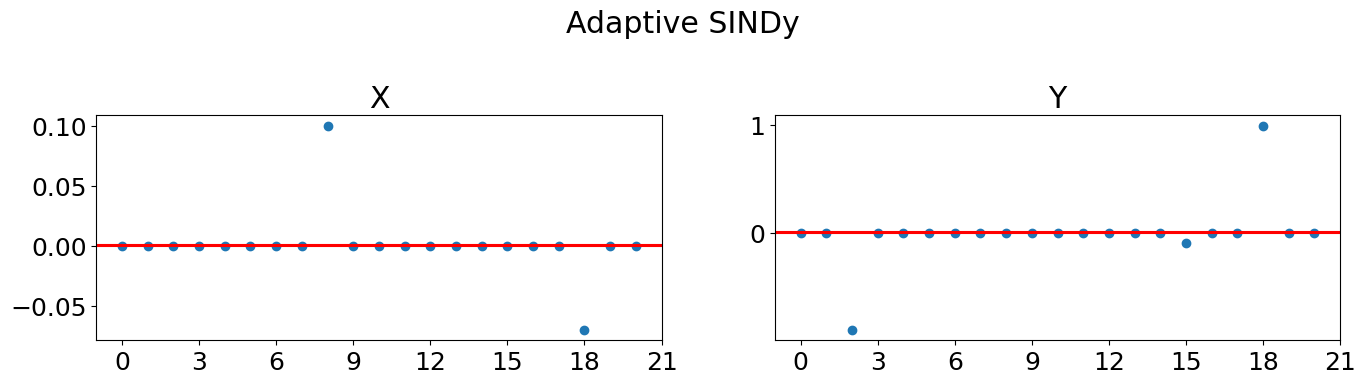

In [10]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [11]:
print(COEFF_ADT)
print(SINE_ADT )
print(XSINE_ADT)
print(COSINE_ADT)
print(XCOSINE_ADT)
print(EXP_ADT)
print(XEXP_ADT)


tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.9041],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.1000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.0949],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0700,  0.9915],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[-0.4935, -1.6746],
        [ 0.0000, -0.1835]], device='cuda:0', requ

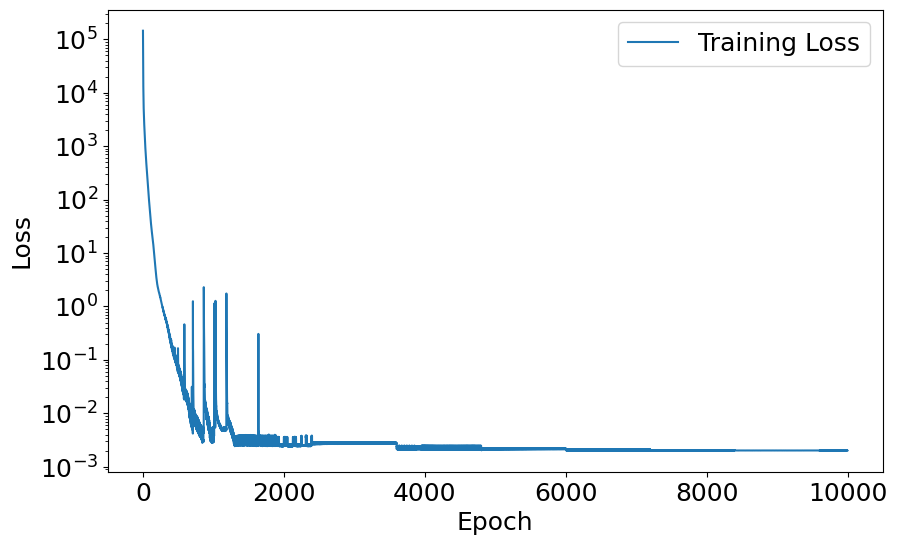

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy(), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(False)
plt.savefig('Loss_plot.jpeg', dpi = 1200)
plt.show()

In [13]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(21, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)

# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, EXP_ADT, XEXP_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)

In [ ]:
# TEMPORAL MODE 1
A1_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1]).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    loss_epoch = 0.0
    for batch_idx, (A_time_deriv, A_cand) in enumerate(train_load):
        A1_out, A2_out  = A1_DT (A_cand), A2_DT (A_cand)
        output_data  = torch.stack((A1_out , A2_out), dim = 1)
        loss_batch   = loss_function (A_time_deriv, output_data) + (1e-3 + torch.abs(Lambda))*torch.linalg.matrix_norm(COEFF_ADT, ord =1)
    
        optim_COEFF_ADT.zero_grad()
        optim_Lambda.zero_grad()
        optim_weights.zero_grad()
        loss_batch.backward()

        with torch.no_grad():
            optim_COEFF_ADT.step()
            optim_Lambda.step()
            optim_weights.step()
        
            COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
            SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
            COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
            XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
            XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
            EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
            XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
            loss_epoch += loss_batch
    
    N = batch_idx + 1        
    Loss_data [epoch] = (loss_epoch/N).detach()
    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)
       
    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

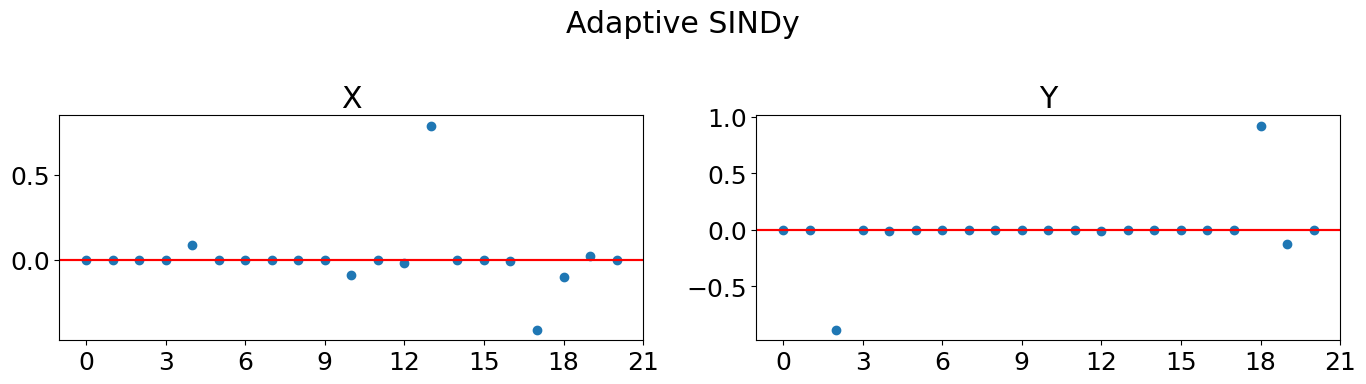

In [15]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

In [16]:
print(COEFF_ADT)
print(SINE_ADT )
print(XSINE_ADT)
print(COSINE_ADT)
print(XCOSINE_ADT)
print(EXP_ADT)
print(XEXP_ADT)

tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.8868],
        [ 0.0000,  0.0000],
        [ 0.0844, -0.0133],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0887,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0193, -0.0071],
        [ 0.7869,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0081,  0.0000],
        [-0.4111,  0.0000],
        [-0.0976,  0.9230],
        [ 0.0211, -0.1214],
        [ 0.0000,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[-0.1099, -2.5062],
        [ 0.2406, -0.0538]], device='cuda:0', requ

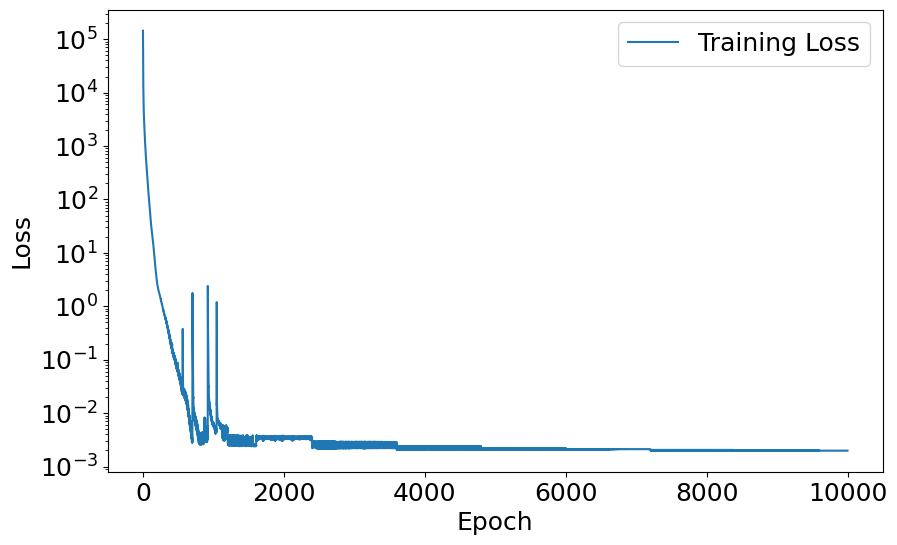

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy(), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(False)
plt.savefig('Loss_plot.jpeg', dpi = 1200)
plt.show()